In [42]:
import requests
import pandas as pd
import time
import matplotlib.pyplot as plt

In [49]:
def get_vacancies_api(query, area=113, per_page=100, pages=5):
    """Получает вакансии через официальное API HH.ru"""
    
    base_url = "https://api.hh.ru/vacancies"
    all_vacancies = []
    
    for page in range(pages):
        params1 = {
            'text': query,
            'area': area,  # 113 - Россия
            'page': page,
            'per_page': per_page,
            'only_with_salary': True,  # Только с указанной зарплатой
            'experience': 'noExperience',
        }
        params2 = {
            'text': query,
            'area': area,  # 113 - Россия
            'page': page,
            'per_page': per_page,
            'only_with_salary': True,  # Только с указанной зарплатой
            'experience': 'between1And3',
        }
        
        try:
            response = requests.get(base_url, params=params1)
            response.raise_for_status()
            data = response.json()
            vacancies1 = data.get('items', [])
            all_vacancies.extend(vacancies1)

            response = requests.get(base_url, params=params2)
            response.raise_for_status()
            data = response.json()
            vacancies2 = data.get('items', [])
            all_vacancies.extend(vacancies2)

            # Проверяем, есть ли еще страницы
            pages_total = data.get('pages', 0)
            if page >= pages_total - 1:
                break
            
            time.sleep(1)
            
        except Exception as e:
            print(f"Ошибка API: {e}")
            break
    
    return all_vacancies

In [50]:
# Получаем список вакансий
vacancies_list = get_vacancies_api(query="дата аналитик", pages=3)
print(f"Всего найдено вакансий: {len(vacancies_list)}")


Всего найдено вакансий: 247


In [45]:
# Преобразуем в DataFrame
data = []
for vac in vacancies_list:
    if vac:
        # Извлекаем нужные поля
        salary = vac.get('salary')
        s = 0
        # Получаем среднюю зарпалту
        if salary:
            s_t = salary.get('to')
            s_f = salary.get('from')
            s = (s_t if s_t else s_f + s_f if s_f else s_t)/2
        row = {
            'id': vac.get('id'),
            'name': vac.get('name'),
            'salary': s,
            'experience': vac.get('experience', {}).get('name'),
            'city': vac['area']['name'] if vac.get('area') else None,
        }
        data.append(row)

df_api = pd.DataFrame(data)
df_api.to_csv('hh_api_vacancies.csv', index=False)

In [46]:
# Группируем по городу и опыту данные, получаем среднюю зп
g_df = df_api.groupby(['city', 'experience'], as_index=False).mean(numeric_only=True)
# Присваиваем каждой переменной зп по МСК и регионам без и с опытом
msk_n_e = float(g_df.query('city == "Москва" and experience == "Нет опыта"').iloc[0, 2])
msk_w_e = float(g_df.query('city == "Москва" and experience == "От 1 года до 3 лет"').iloc[0,2])
n_msk_n_e = float(g_df.query('city != "Москва" and experience == "Нет опыта"')['salary'].mean())
n_msk_w_e = float(g_df.query('city != "Москва" and experience == "От 1 года до 3 лет"')['salary'].mean())

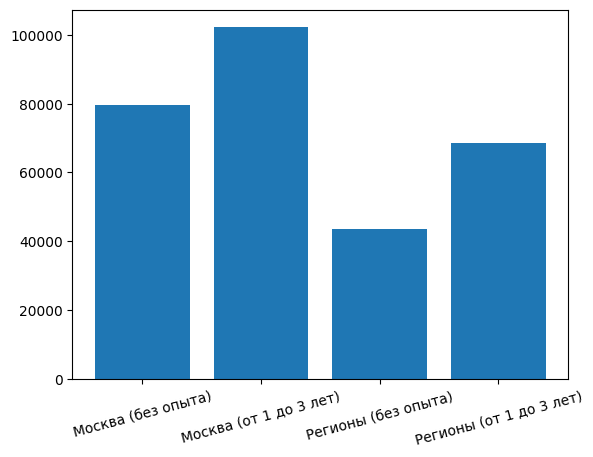

In [47]:
# Строим гистограмму, в которой показывается сравнение между средней зп по МСК и регионам в зависимости от опыта
x = ['Москва (без опыта)', 'Москва (от 1 до 3 лет)', 'Регионы (без опыта)', 'Регионы (от 1 до 3 лет)']
y = [msk_n_e, msk_w_e, n_msk_n_e, n_msk_w_e]
plt.bar(x, y)
plt.xticks(rotation=15)
plt.show()